In [1]:
#!pip install -U pandas
#!pip install -U numpy
#!pip install -U seaborn
#!pip install -U matplotlib
#!pip install -U scikit-learn
#https://stackoverflow.com/questions/36763853/plotting-a-set-of-given-points-to-form-a-closed-curve-in-matplotlib!pip install -U lightgbm

# Final Project 

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

Target feature: the `'EndDate'` column equals `'No'`.

Primary metric: AUC-ROC.

Additional metric: Accuracy.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Project Plan
### Basic exploration:
    1. Download the data
    2. Explore, check NaNs, check duplicated.
    3. Check Dtypes, convert them if needed.
    4. Check the target variable - check unbalancing.
    

### Special feature engineerings for this dataset:
    1. Merge tables if needed, treat NaNs if they created in the process.
    2. Visualize distributions to check outliers, remove them if there are any.
    3. visualize correlations between variables.
    
### Preperae the data for modeling:
    1. test test split.
    2. scalarization if needed.
    
### Modeling
    1. use different classification models. use dummy classifier model as sanity check.
    2. use correct metric to rate the classification models.
    3. we will use AUC-ROC and accuracy because these are the project instructions. we could use f1 metric as well.
    4. visualization of AUC-ROC

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,\
    classification_report, plot_confusion_matrix, precision_score, recall_score,\
    plot_roc_curve, roc_curve, auc, f1_score, roc_auc_score, SCORERS
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Load data and EDA

In [4]:
data = {}
for df in ["personal", "contract", "phone", "internet"]:
    try:
        data[df] = pd.read_csv(f"/datasets/final_provider/{df}.csv")
    except:
        data[df] = pd.read_csv(f"./final_provider/{df}.csv")

for df in data:
    data[df] = data[df].applymap(lambda s: s.lower() if type(s) ==
                                 str else s, na_action='ignore')
    data[df].columns = [x.lower() for x in data[df].columns]
    display(f"df name: {df.upper()}")
    display(f"shape: {data[df].shape}")
    display(data[df].sample(10))
    display("***************************************************************************************")

'df name: PERSONAL'

'shape: (7043, 5)'

,customerid,gender,seniorcitizen,partner,dependents
5496,2208-nkvvh,male,0,yes,yes
3815,9306-cpcbc,female,0,no,no
3601,1552-czcll,female,0,yes,yes
5503,1757-tcatg,male,0,yes,yes
4075,3160-tyxlt,male,0,no,no
6825,5022-kvdqt,male,0,no,no
6146,4009-alqfh,female,0,no,no
5274,6723-wsnty,female,1,yes,no
2976,4830-faxfm,male,0,no,yes
6798,7562-uxtpg,female,0,no,no


'***************************************************************************************'

'df name: CONTRACT'

'shape: (7043, 8)'

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
6023,4698-kvllg,2015-11-01,no,two year,no,credit card (automatic),19.60,967.9
1943,7442-ygzfk,2020-01-01,no,month-to-month,yes,credit card (automatic),49.80,49.8
2763,2250-ivbwa,2014-10-01,no,month-to-month,no,electronic check,81.05,5135.35
366,9069-lgeul,2018-03-01,no,month-to-month,yes,bank transfer (automatic),59.95,1406
1034,8146-qqkzh,2014-03-01,no,two year,no,bank transfer (automatic),81.85,5924.4
951,8584-kmvxd,2019-06-01,no,month-to-month,no,electronic check,75.60,535.55
2215,4312-gvynh,2014-04-01,no,two year,yes,bank transfer (automatic),49.85,3370.2
2544,7285-klotr,2019-02-01,no,one year,no,electronic check,78.85,876.75
331,9498-fimxl,2019-06-01,no,one year,yes,mailed check,19.20,161.95
3490,7743-exurx,2019-03-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,51.05,415.05


'***************************************************************************************'

'df name: PHONE'

'shape: (6361, 2)'

,customerid,multiplelines
3257,6080-tcmyc,yes
2717,5266-pfrqk,no
2522,9506-uxusk,no
1598,7801-cednv,no
5167,0156-fvpta,no
2553,7209-jcuds,no
4423,3688-fthlt,yes
5239,1539-lnkhm,no
4172,4884-tvuqf,yes
3427,2129-alkbs,yes


'***************************************************************************************'

'df name: INTERNET'

'shape: (5517, 8)'

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
1341,8593-whyhv,fiber optic,no,no,no,no,no,yes
2116,7629-wixzf,dsl,yes,no,no,no,no,yes
4098,5115-gzdel,dsl,yes,yes,yes,yes,yes,yes
4181,4254-qpede,dsl,yes,yes,yes,yes,yes,yes
934,6994-orcwg,dsl,no,yes,no,no,no,no
1247,5014-wuqmg,fiber optic,yes,yes,yes,no,no,yes
1491,9281-pkkze,dsl,no,no,no,no,yes,yes
3463,3891-nlxjb,dsl,yes,yes,no,yes,no,no
2583,0253-zteob,dsl,no,yes,no,yes,yes,yes
3620,1853-udxbw,fiber optic,no,no,no,no,no,no


'***************************************************************************************'

In [5]:
for df in data:
    data[df].info()
    display("***********************************************************")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'***********************************************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


'***********************************************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


'***********************************************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'***********************************************************'

* we dont see nulls, but we see that there are differences between the tables in the number of the lines.
* the reason is probably that some of the client have both phone and internet and some not.
* lets check duplicates:

In [6]:
for df in data:
    print(f"{df} Duplicated: {data[df].duplicated().sum()}")

personal Duplicated: 0
contract Duplicated: 0
phone Duplicated: 0
internet Duplicated: 0


### looking into the target variable

In [7]:
data["contract"]["enddate"].value_counts()

no                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate, dtype: int64

* we will create a churn column:
* if "enddate" != "no" that means the customer churn.
* 0 - if stayed, 1 if churn.

In [8]:
data["contract"]["churn"] = (data["contract"]["enddate"] != "no").astype('int')

In [9]:
data["contract"]['churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: churn, dtype: float64

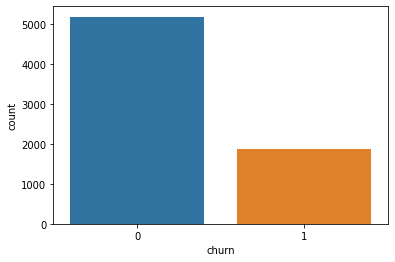

In [10]:
sns.countplot(data=data["contract"], x='churn');

* we have here unbalanced data - 73% to 27%.

### create one dataframe

In [11]:
df = data['personal']\
    .merge(data['contract'], on="customerid")\
    .merge(data["phone"], how='left', on="customerid")\
    .merge(data["internet"], how='left', on="customerid")

df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,totalcharges,churn,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-vhveg,female,0,yes,no,2020-01-01,no,month-to-month,yes,electronic check,...,29.85,0,NaN,dsl,no,yes,no,no,no,no
1,5575-gnvde,male,0,no,no,2017-04-01,no,one year,no,mailed check,...,1889.5,0,no,dsl,yes,no,yes,no,no,no
2,3668-qpybk,male,0,no,no,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,...,108.15,1,no,dsl,yes,yes,no,no,no,no
3,7795-cfocw,male,0,no,no,2016-05-01,no,one year,no,bank transfer (automatic),...,1840.75,0,NaN,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,female,0,no,no,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,...,151.65,1,no,fiber optic,no,no,no,no,no,no


* we will add "time length" column, indicates the number of days the customer registrated.

In [12]:
def length(r):
    if r["enddate"] == 'no':
        return pd.to_datetime('2020-02-01') - pd.to_datetime(r['begindate'])
    else:
        return pd.to_datetime(r['enddate']) - pd.to_datetime(r['begindate'])


df['time_length'] = df.apply(length, axis=1).dt.days

### labeling variables:

In [13]:
df.rename(columns={"multiplelines": "phone"}, inplace=True)

* in the phone column, we will label it like this:
    * 0 - someone hasnt phone
    * 1- have phone but not multiline
    * 2 - have multiline
    

In [14]:
def fix_phone(x):
    if pd.isnull(x):
        x = 0
    elif x == 'no':
        x = 1
    elif x == 'yes':
        x = 2
    return x


df["phone"] = df["phone"].apply(fix_phone)

* same with the "internet service" column:

In [15]:
df["internetservice"].value_counts()

fiber optic    3096
dsl            2421
Name: internetservice, dtype: int64

In [16]:
def fix_internet(x):
    if pd.isnull(x):
        x = 0
    elif x == 'dsl':
        x = 1
    elif x == 'fiber optic':
        x = 2
    return x


df["internetservice"] = df["internetservice"].apply(fix_internet)

* same with the type column:

In [17]:
df["type"].value_counts()

month-to-month    3875
two year          1695
one year          1473
Name: type, dtype: int64

In [18]:
def fix_type(x):
    if x == "month-to-month":
        x = 0
    elif x == 'one year':
        x = 1
    elif x == 'two year':
        x = 2
    return x


df["type"] = df["type"].apply(fix_type)

### fixing the "total charges" column:

* if we try to convert "total charges" to numeric, we get an error. lets see how much non-numeric-convertables values are:

In [19]:
pd.to_numeric(df["totalcharges"], errors='coerce').isna().sum()

11

* there are 11 non numeric values in this column, lets check it:
* the errors='coerce' make this values nulls:

In [20]:
df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors='coerce')

In [21]:
df[pd.isnull(df["totalcharges"])]

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,churn,phone,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,time_length
488,4472-lvygi,female,0,yes,yes,2020-02-01,no,2,yes,bank transfer (automatic),...,0,0,1,yes,no,yes,yes,yes,no,0
753,3115-czmzd,male,0,no,yes,2020-02-01,no,2,no,mailed check,...,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0
936,5709-lvoeq,female,0,yes,yes,2020-02-01,no,2,no,mailed check,...,0,1,1,yes,yes,yes,no,yes,yes,0
1082,4367-nuyao,male,0,yes,yes,2020-02-01,no,2,no,mailed check,...,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1340,1371-dwpaz,female,0,yes,yes,2020-02-01,no,2,no,credit card (automatic),...,0,0,1,yes,yes,yes,yes,yes,no,0
3331,7644-omvmy,male,0,yes,yes,2020-02-01,no,2,no,mailed check,...,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3826,3213-vvolg,male,0,yes,yes,2020-02-01,no,2,no,mailed check,...,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4380,2520-sgtta,female,0,yes,yes,2020-02-01,no,2,no,mailed check,...,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0
5218,2923-arzlg,male,0,yes,yes,2020-02-01,no,1,yes,mailed check,...,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0
6670,4075-wkniu,female,0,yes,yes,2020-02-01,no,2,no,mailed check,...,0,2,1,no,yes,yes,yes,yes,no,0


* we see that all these nulls are from 2020-02-01 , that means that they are new customers, so we will fill 0 in the total charges.

In [22]:
df["totalcharges"] = df["totalcharges"].fillna(0)
df["totalcharges"] = df["totalcharges"].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   begindate         7043 non-null   object 
 6   enddate           7043 non-null   object 
 7   type              7043 non-null   int64  
 8   paperlessbilling  7043 non-null   object 
 9   paymentmethod     7043 non-null   object 
 10  monthlycharges    7043 non-null   float64
 11  totalcharges      7043 non-null   float64
 12  churn             7043 non-null   int64  
 13  phone             7043 non-null   int64  
 14  internetservice   7043 non-null   int64  
 15  onlinesecurity    5517 non-null   object 
 16  onlinebackup      5517 non-null   object 


* we could see now that the "totalcharges" is a float data type.

### fix the internet bonus services

* now we will fix all the internet features:
* we will replace the nulls and the "no" values with 0, and yes with 1.

In [23]:
for col in ['onlinesecurity', 'onlinebackup',
            'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
            'paperlessbilling', 'partner', 'dependents']:
    df[col] = (df[col] == 'yes').astype('int')

df.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,churn,phone,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,time_length
0,7590-vhveg,female,0,1,0,2020-01-01,no,0,1,electronic check,...,0,0,1,0,1,0,0,0,0,31
1,5575-gnvde,male,0,0,0,2017-04-01,no,1,0,mailed check,...,0,1,1,1,0,1,0,0,0,1036
2,3668-qpybk,male,0,0,0,2019-10-01,2019-12-01 00:00:00,0,1,mailed check,...,1,1,1,1,1,0,0,0,0,61
3,7795-cfocw,male,0,0,0,2016-05-01,no,1,0,bank transfer (automatic),...,0,0,1,1,0,1,1,0,0,1371
4,9237-hqitu,female,0,0,0,2019-09-01,2019-11-01 00:00:00,0,1,electronic check,...,1,1,2,0,0,0,0,0,0,61


### visualize correlations:

* we will do it with absolute value to see the magnitude of the variables on the target.

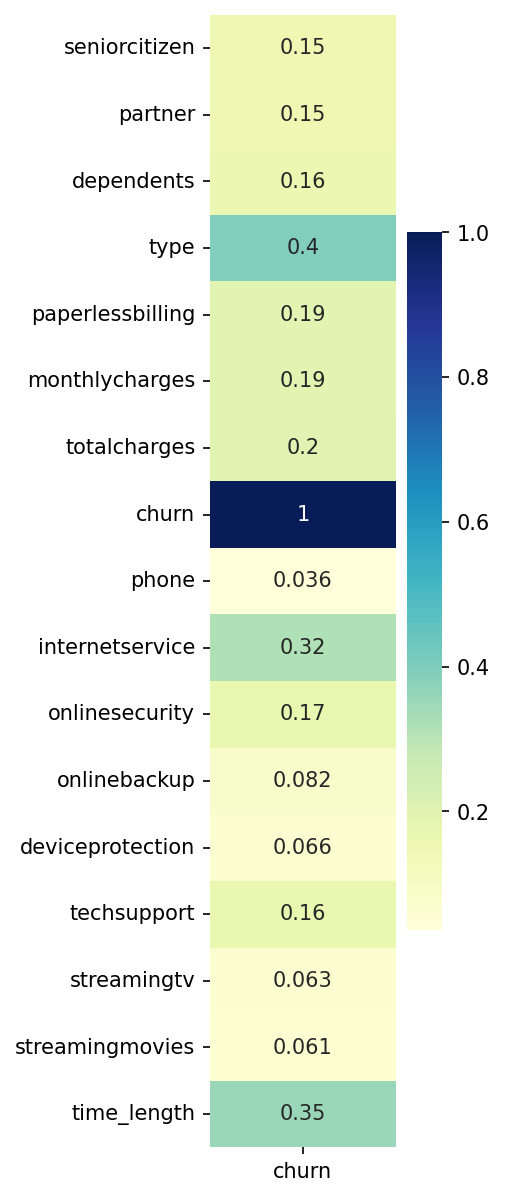

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2, 10), dpi=150)
sns.heatmap(abs(df.corr()[['churn']]), annot=True, cmap="YlGnBu");

### drop unnecessary columns:

In [25]:
df = df.drop(columns=['customerid', 'begindate', 'enddate'])

In [26]:
df.head()

,gender,seniorcitizen,partner,dependents,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,phone,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,time_length
0,female,0,1,0,0,1,electronic check,29.85,29.85,0,0,1,0,1,0,0,0,0,31
1,male,0,0,0,1,0,mailed check,56.95,1889.50,0,1,1,1,0,1,0,0,0,1036
2,male,0,0,0,0,1,mailed check,53.85,108.15,1,1,1,1,1,0,0,0,0,61
3,male,0,0,0,1,0,bank transfer (automatic),42.30,1840.75,0,0,1,1,0,1,1,0,0,1371
4,female,0,0,0,0,1,electronic check,70.70,151.65,1,1,2,0,0,0,0,0,0,61


### OHE

* there remains only two categorical columns, we will do OHE to make them numerical:

In [27]:
df = pd.concat([df.drop(columns=['gender', 'paymentmethod']), pd.get_dummies(
    df[['gender', 'paymentmethod']], drop_first=True)], axis=1)

In [28]:
df.head()

,seniorcitizen,partner,dependents,type,paperlessbilling,monthlycharges,totalcharges,churn,phone,internetservice,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,time_length,gender_male,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check
0,0,1,0,0,1,29.85,29.85,0,0,1,...,1,0,0,0,0,31,0,0,1,0
1,0,0,0,1,0,56.95,1889.50,0,1,1,...,0,1,0,0,0,1036,1,0,0,1
2,0,0,0,0,1,53.85,108.15,1,1,1,...,1,0,0,0,0,61,1,0,0,1
3,0,0,0,1,0,42.30,1840.75,0,0,1,...,0,1,1,0,0,1371,1,0,0,0
4,0,0,0,0,1,70.70,151.65,1,1,2,...,0,0,0,0,0,61,0,0,1,0


### Checking outliers

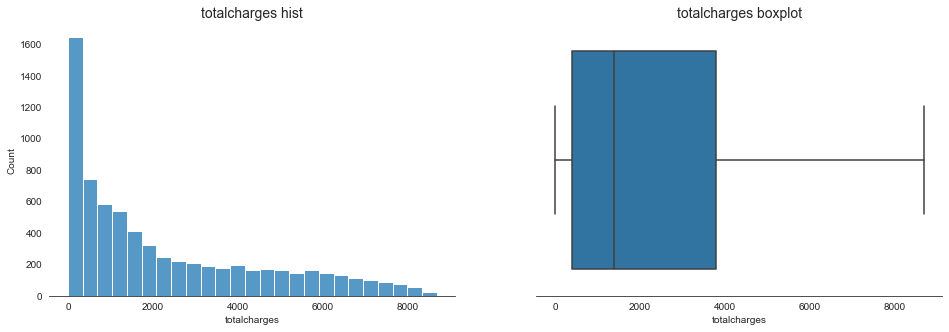

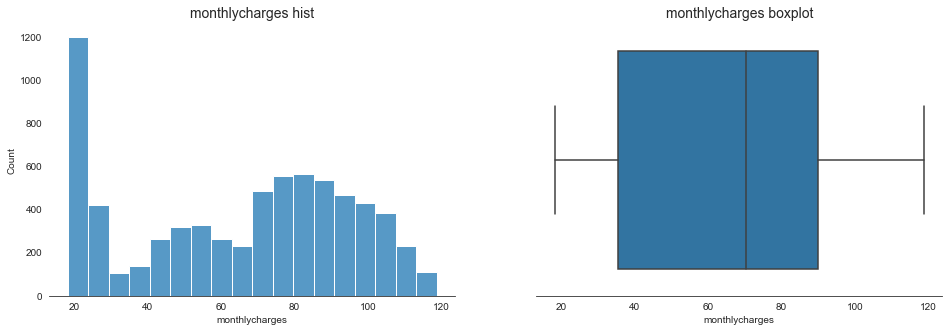

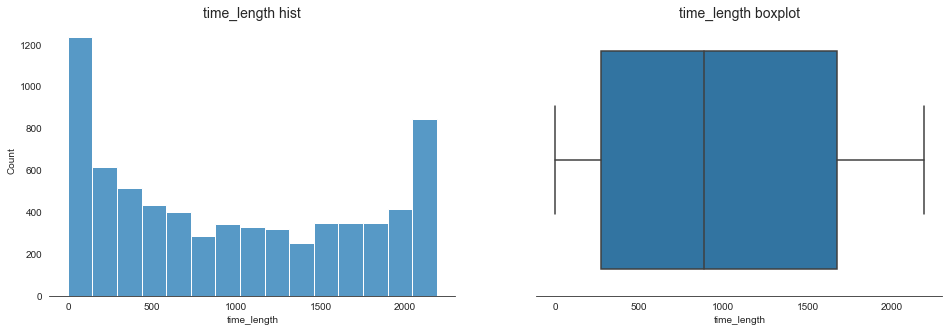

In [29]:
sns.set_style('white')
for col in ['totalcharges', 'monthlycharges', 'time_length']:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.histplot(data=df, x=col, ax=axes[0])
    sns.boxplot(data=df, x=col, ax=axes[1])
    sns.despine(left=True)
    axes[0].set_title(f'{col} hist', fontsize=14)
    axes[1].set_title(f'{col} boxplot', fontsize=14);

* we dont see here extreme outliers, we will remain it as it is.

### devide the data to train test, and treat imbalancing:

In [30]:
X = df.drop('churn', axis=1)
y = df['churn']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

## Models

### Metric functions:

In [32]:

d = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "AUC": []
}
models_names = []
models = []


def plot_roc():
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[10, 4], dpi=200)
    axes.set_title("ROC curve for the models")
    for i in range(len(models)):
        plot_roc_curve(models[i], X_test, y_test, ax=axes,
                       label=f"{models_names[i]}, AUC={d['AUC'][i]:.2f}")


def check(model, x_test, y_test, model_name, d, models_names):
    preds = model.predict(x_test)
    d["accuracy"].append(accuracy_score(y_test, preds))
    d["precision"].append(precision_score(y_test, preds))
    d["recall"].append(recall_score(y_test, preds))
    d["f1_score"].append(f1_score(y_test, preds))
    y_probs = model.predict_proba(X_test)[:, 1]
    d["AUC"].append(roc_auc_score(y_test, y_probs))
    models_names.append(model_name)
    models.append(model)
    d = pd.DataFrame(d, index=models_names).sort_values(
        ["AUC"], ascending=False)
    display(d)
#     print(classification_report(y_test,preds))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2), dpi=150)
    fig.suptitle('Confusion matrix')
    plot_confusion_matrix(model, x_test, y_test, ax=axes[0], cmap="YlGnBu")
    plot_confusion_matrix(model, x_test, y_test,
                          normalize='all', ax=axes[1], cmap="YlGnBu")
    plot_roc()

### basic model - dummy classifier.
* we will create dummy classifier model as a sanity check:

In [33]:
from sklearn.dummy import DummyClassifier

In [34]:
dum = DummyClassifier()

dum.fit(X_train, y_train)

DummyClassifier()

,accuracy,precision,recall,f1_score,AUC
dummy,0.724823,0.0,0.0,0.0,0.5


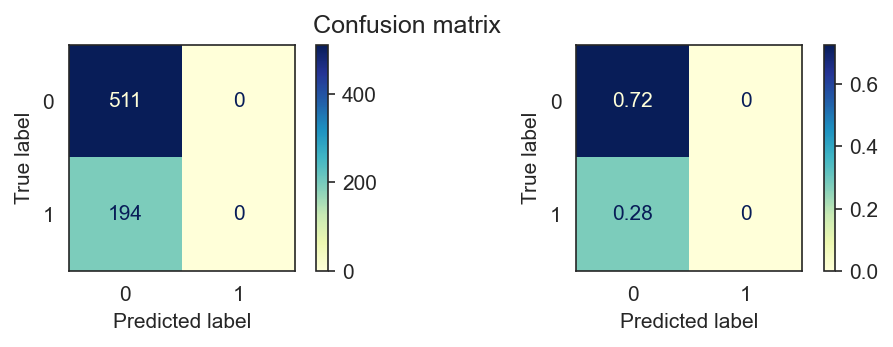

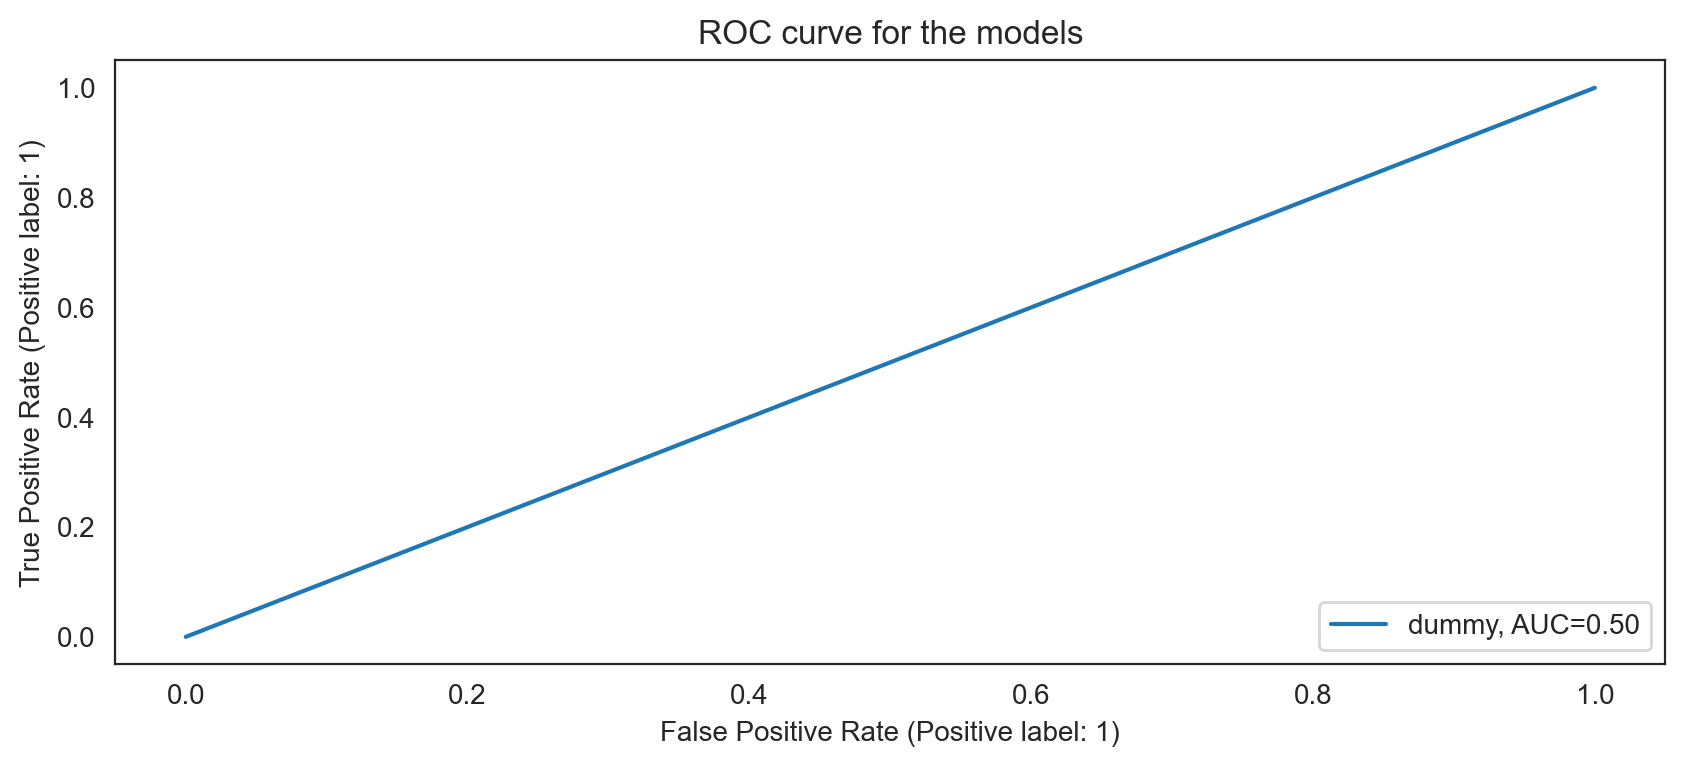

In [35]:
check(dum, X_test, y_test, "dummy", d, models_names)

### Logistic regression:

In [36]:
pipe = Pipeline(steps=[('sc', MinMaxScaler()),
                       ('lr', LogisticRegression(random_state=42, class_weight="balanced"))])

In [37]:
logistic_params = {'lr__penalty': ['elasticnet'], 'lr__solver': ['saga'],
                   'lr__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'lr__random_state': [42], }
grid_lr = GridSearchCV(
    pipe, param_grid=logistic_params, scoring='roc_auc', refit='accuracy')
grid_lr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             param_grid={'lr__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1],
                         'lr__penalty': ['elasticnet'],
                         'lr__random_state': [42], 'lr__solver': ['saga']},
             refit='accuracy', scoring='roc_auc')

,accuracy,precision,recall,f1_score,AUC
logistic regression,0.770213,0.554422,0.840206,0.668033,0.869813
dummy,0.724823,0.000000,0.000000,0.000000,0.500000


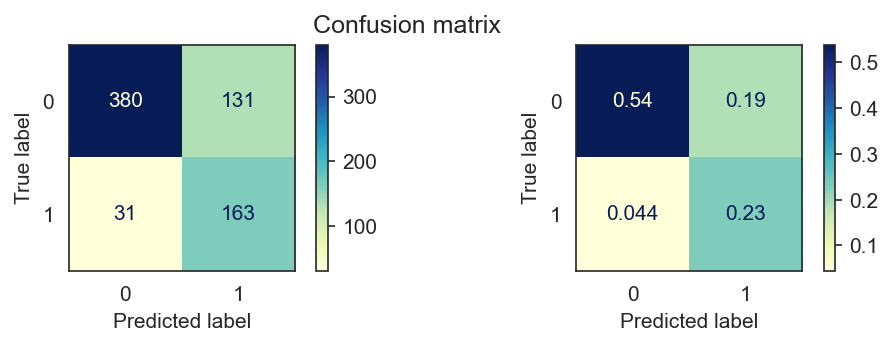

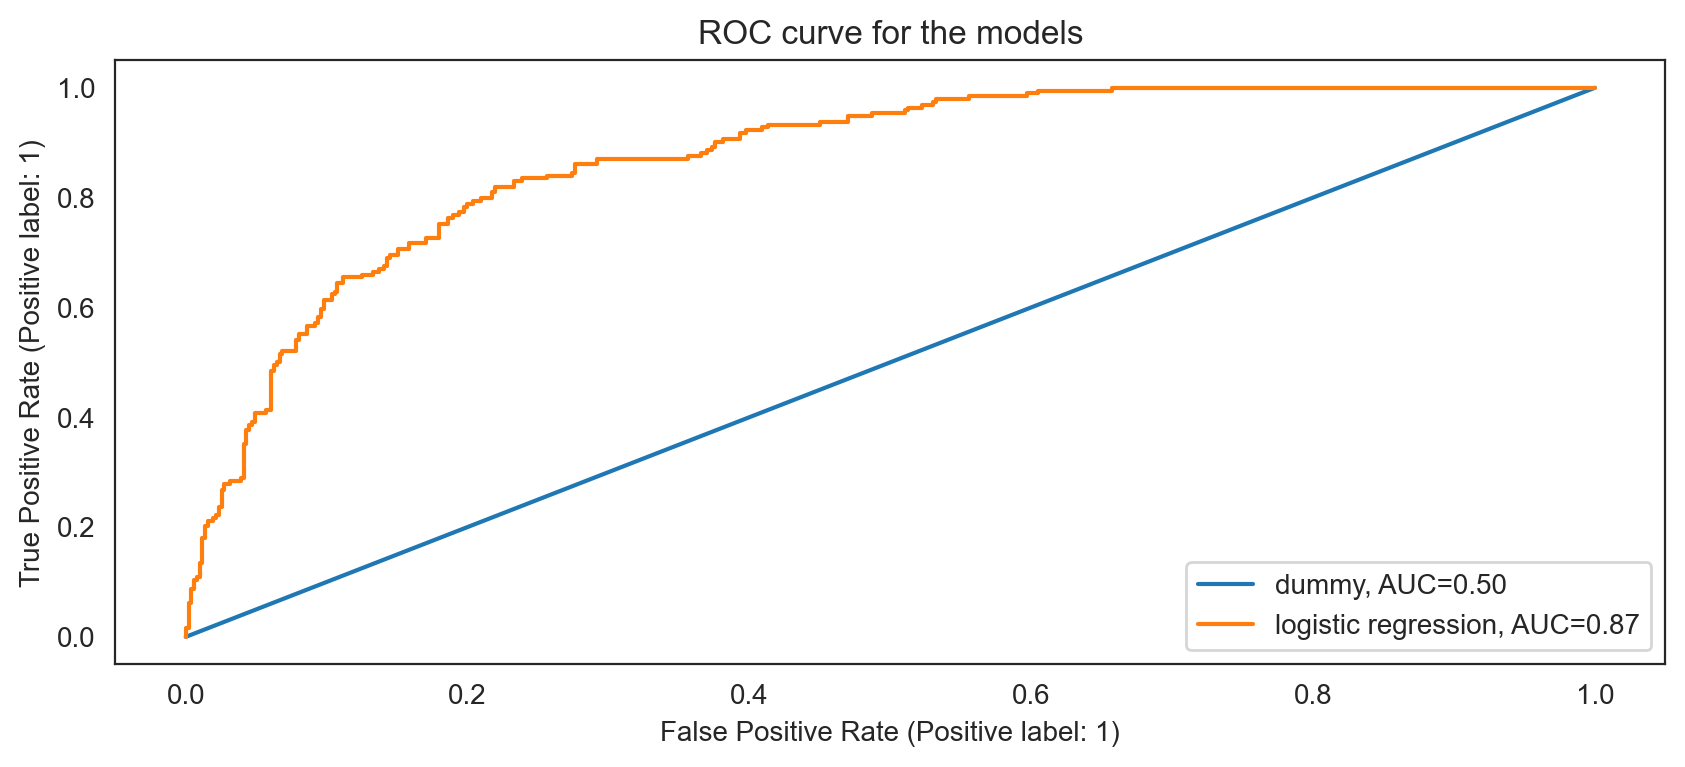

In [38]:
check(grid_lr, X_test, y_test, "logistic regression", d, models_names)

### Random forest

In [39]:
param_grid = {'n_estimators': [130, 135, 140],
              'max_depth':  [7, 8, 9, 10, 11, 12]}
rfc = RandomForestClassifier(random_state=42, class_weight="balanced")
forest_grid = GridSearchCV(
    rfc, param_grid, scoring='roc_auc', refit='accuracy')
forest_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12],
                         'n_estimators': [130, 135, 140]},
             refit='accuracy', scoring='roc_auc')

In [40]:
forest_grid.best_params_

{'max_depth': 8, 'n_estimators': 135}

,accuracy,precision,recall,f1_score,AUC
random_forest,0.811348,0.622490,0.798969,0.699774,0.891823
logistic regression,0.770213,0.554422,0.840206,0.668033,0.869813
dummy,0.724823,0.000000,0.000000,0.000000,0.500000


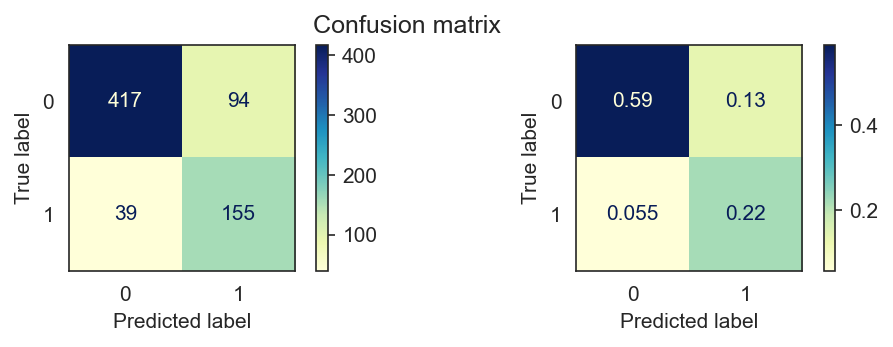

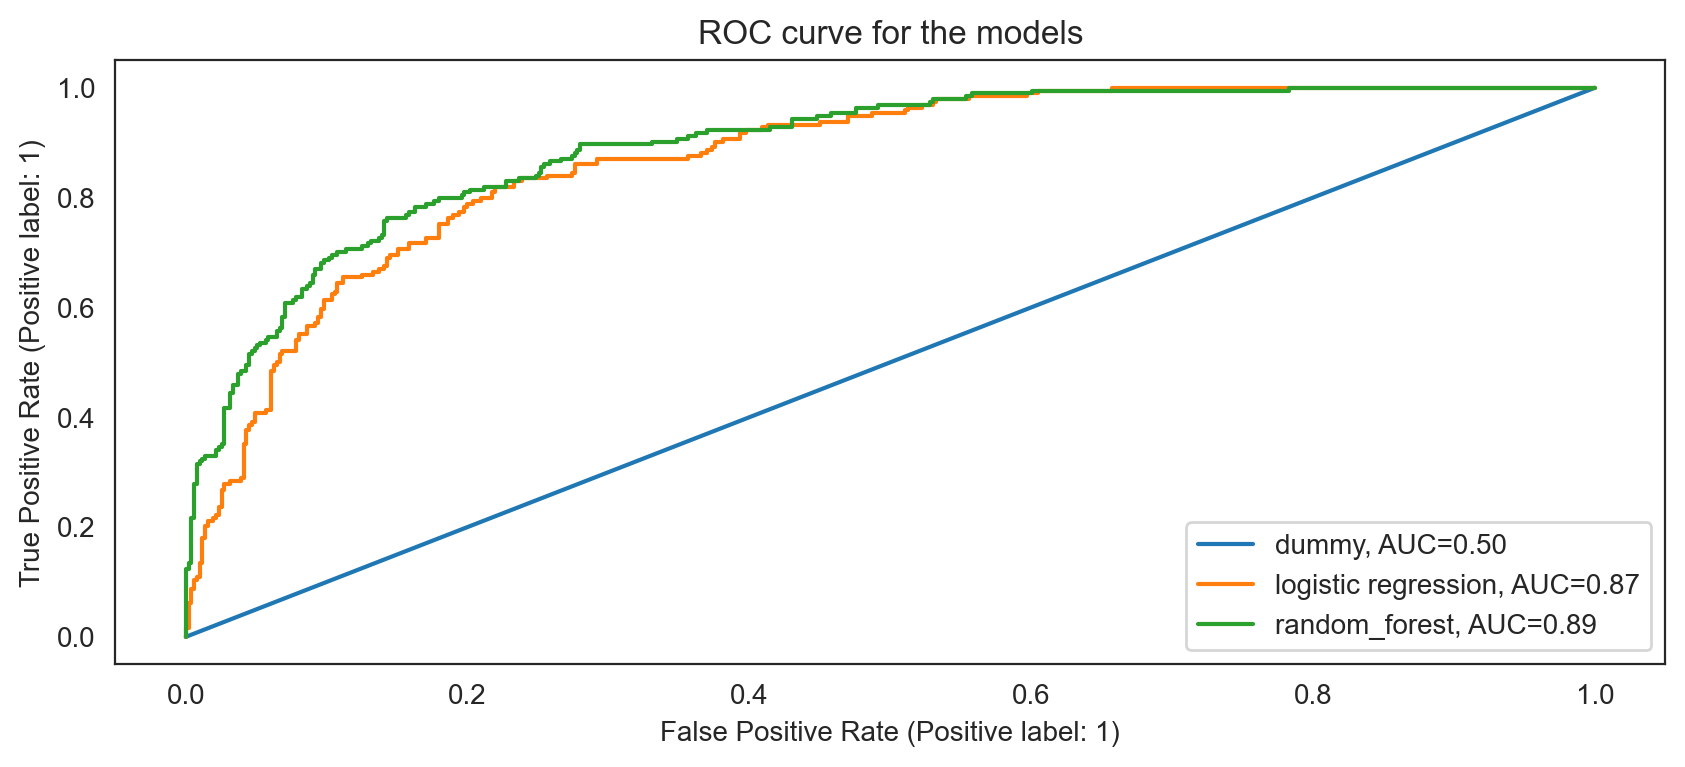

In [41]:
check(forest_grid, X_test, y_test, "random_forest", d, models_names)

### Gradient boosting

In [42]:
gb = GradientBoostingClassifier()

gradient_grid = {'n_estimators': [175, 230], 'learning_rate': [0.35, 0.4],
                 'max_depth': [3, 4, 5, 7], 'random_state': [42], }


boost_grid = GridSearchCV(
    gb, gradient_grid, scoring='roc_auc', refit='accuracy')

boost_grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.35, 0.4],
                         'max_depth': [3, 4, 5, 7], 'n_estimators': [175, 230],
                         'random_state': [42]},
             refit='accuracy', scoring='roc_auc')

In [43]:
boost_grid.best_params_

{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 230, 'random_state': 42}

,accuracy,precision,recall,f1_score,AUC
gradient boosting,0.900709,0.887500,0.731959,0.802260,0.949558
random_forest,0.811348,0.622490,0.798969,0.699774,0.891823
logistic regression,0.770213,0.554422,0.840206,0.668033,0.869813
dummy,0.724823,0.000000,0.000000,0.000000,0.500000


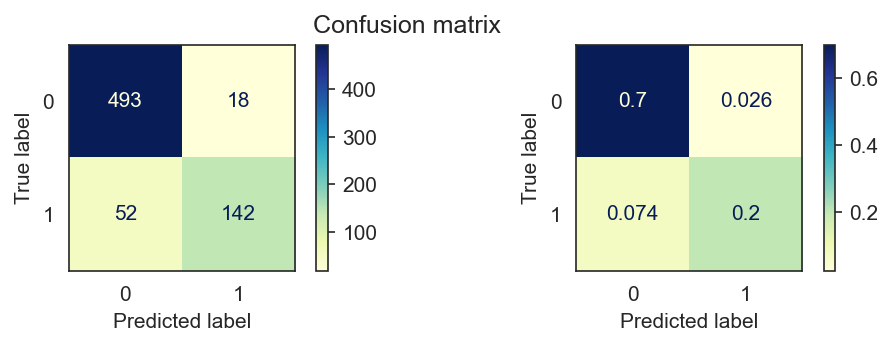

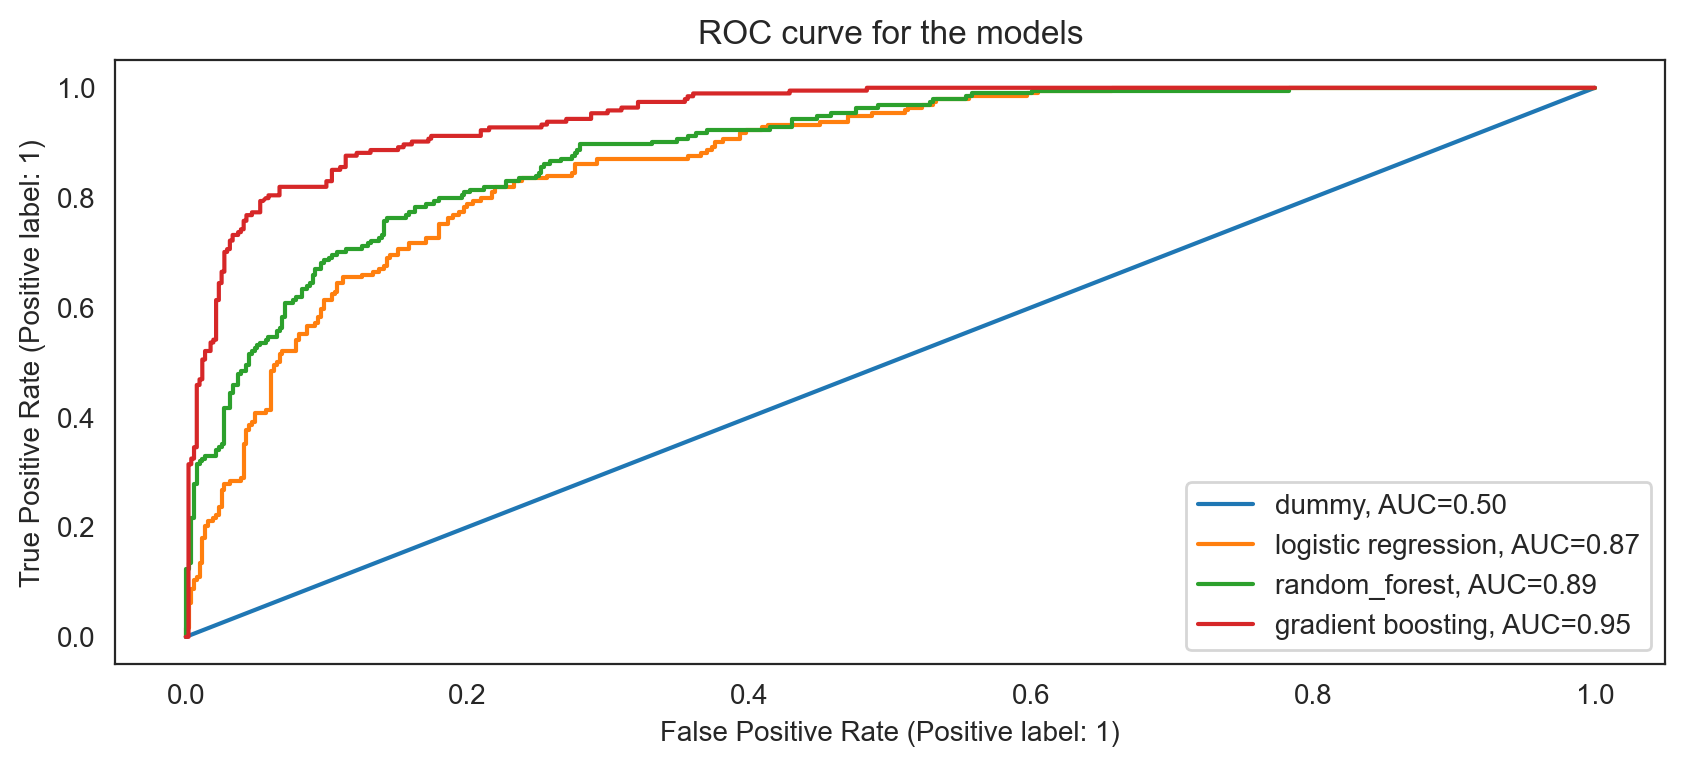

In [44]:
check(boost_grid, X_test, y_test, "gradient boosting", d, models_names)

### LightGbm

In [ ]:

param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'learning_rate': [0.15, 0.2],
    'n_estimators': [175, 200, 225]
}

lgb = LGBMClassifier()

lgbm = GridSearchCV(lgb, param_grid=param_grid, scoring='roc_auc')
lgbm.fit(X_train, y_train)

lgbm.best_params_

In [ ]:
check(lgbm, X_test, y_test, "lgbm", d, models_names)

### Conclusion:

* we have arranged and cleaned the data.
* we trained our models and tuned hiper parameters using grid-search cv.
* 2 from our models passed the highest threshold of 88%
* gradient boosting and lightgbm with the best scores.
